In [1]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import zipfile
import io
import scikitplot as skplt
import random
from sklearn.metrics import precision_score, recall_score, plot_confusion_matrix, auc, roc_curve, roc_auc_score

plt.style.use('seaborn-white')
plt.rcParams.update({'font.size':18})

In [2]:
# Si se está ejecutando en Google Colab definir colab=True
colab = False
# Si se está ejecutando localmente especificar el directorio en dataset_path
dataset_path = 'D:/UDENAR/Electronic Engineering/Trabajo de Grado/Results/Teager/Classification/CardioDeep2.1/'

if colab:
    dataset_path = ''
    from google.colab import files
    uploaded = files.upload()
    data = zipfile.ZipFile(io.BytesIO(uploaded['Datasets.zip']), 'r')
    data.extractall()
else:
    print('Ejecutando en sistema local')

Ejecutando en sistema local


In [3]:
# Normalización de las imágenes para la etapa de entrenamiento y validación
data_transforms = {
    'train':transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val':transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test':transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [4]:
# Crea los datasets y dataloaders con un batch de 4 imágenes, y aplica las transformaciones
image_datasets = {x: datasets.ImageFolder(dataset_path+x, data_transforms[x])
                      for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=1, shuffle=True,
                                              num_workers=2) for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes # nombres de las categorias
# Selecciona la GPU o CPU como dispositivo para realizar las operaciones y
# almacenar variables
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [5]:
res_model = torch.load('ft_resnet152.pt')
res_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [6]:
vgg_model = torch.load('ft_vgg16.pt')
vgg_model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [7]:
auc_scores = {'ResNet152':0, 'VGG16':0}
roc_values = {'ResNet152':[], 'VGG16':[]}
for model, cnn_type, i in zip([res_model, vgg_model], ['ResNet152', 'VGG16'], range(2)):
    pred_prob = []
    test_labels = []
    running_corrects = 0
    print('-------------------------')
    with torch.no_grad():

        for inputs, labels in dataloaders['test']:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            l = np.array(labels.cpu())
            print(outputs)
            for output, i in zip(outputs.cpu(), range(4)):
                output = np.array(output)
                prob = np.exp(output)/np.exp(output).sum()
                print(prob)
                pred_prob.append(prob[l.item(i)])
                test_labels.append(l.item(i))

-------------------------
tensor([[-2.2285,  2.3763]], device='cuda:0')
[0.00990492 0.9900951 ]
tensor([[ 5.9331, -5.6603]], device='cuda:0')
[9.9999076e-01 9.2268710e-06]
tensor([[-4.5363,  5.0324]], device='cuda:0')
[6.9873902e-05 9.9993014e-01]
tensor([[-3.5091,  3.7837]], device='cuda:0')
[6.7999243e-04 9.9931997e-01]
tensor([[-4.4883,  4.5818]], device='cuda:0')
[1.1503524e-04 9.9988496e-01]
tensor([[ 3.3922, -3.2553]], device='cuda:0')
[0.9987043  0.00129564]
tensor([[-1.2844,  1.5444]], device='cuda:0')
[0.05578917 0.9442108 ]
tensor([[ 6.4395, -6.1152]], device='cuda:0')
[9.9999648e-01 3.5280746e-06]
tensor([[ 1.1219, -1.0446]], device='cuda:0')
[0.89720166 0.10279839]
tensor([[-4.4759,  4.6397]], device='cuda:0')
[1.09925444e-04 9.99890029e-01]
tensor([[-1.6939,  1.9234]], device='cuda:0')
[0.0261524  0.97384757]
tensor([[-2.8834,  3.1162]], device='cuda:0')
[0.00247374 0.9975263 ]
tensor([[-4.4198,  4.6477]], device='cuda:0')
[1.1534625e-04 9.9988461e-01]
tensor([[-3.9922,  4

[0.29081008 0.70918995]
tensor([[ 6.2298, -5.8556]], device='cuda:0')
[9.9999434e-01 5.6411432e-06]
tensor([[ 3.7752, -3.6862]], device='cuda:0')
[9.9942553e-01 5.7451660e-04]
tensor([[ 3.6484, -3.6443]], device='cuda:0')
[9.993200e-01 6.800383e-04]
tensor([[-2.3022,  2.5216]], device='cuda:0')
[0.0079725  0.99202746]
tensor([[ 3.8254, -3.5504]], device='cuda:0')
[9.9937415e-01 6.2582549e-04]
tensor([[-1.9166,  2.1937]], device='cuda:0')
[0.01613776 0.9838622 ]
tensor([[-0.1621,  0.3338]], device='cuda:0')
[0.37852144 0.6214785 ]
tensor([[-2.4776,  2.6999]], device='cuda:0')
[0.00561073 0.99438924]
tensor([[-1.1444,  1.2321]], device='cuda:0')
[0.08497776 0.91502225]
tensor([[ 4.2158, -4.0189]], device='cuda:0')
[9.9973476e-01 2.6521613e-04]
tensor([[-2.9767,  3.2135]], device='cuda:0')
[0.00204521 0.9979548 ]
tensor([[ 2.4029, -2.2363]], device='cuda:0')
[0.9904276  0.00957241]
tensor([[-2.5972,  2.7714]], device='cuda:0')
[0.00463877 0.99536127]
tensor([[-0.6168,  0.7283]], device='c

[0.01945042 0.9805496 ]
tensor([[-2.7935,  3.0039]], device='cuda:0')
[0.00302599 0.99697405]
tensor([[-0.9984,  1.3182]], device='cuda:0')
[0.08975847 0.91024154]
tensor([[ 3.4250, -3.1336]], device='cuda:0')
[0.99858415 0.00141586]
tensor([[ 6.5974, -6.5305]], device='cuda:0')
[9.99998e-01 1.98899e-06]
tensor([[-1.7785,  2.0408]], device='cuda:0')
[0.02147281 0.9785272 ]
tensor([[ 5.3893, -5.2214]], device='cuda:0')
[9.9997532e-01 2.4648702e-05]
tensor([[-1.2513,  1.5153]], device='cuda:0')
[0.05915779 0.94084215]
tensor([[-2.6258,  2.8704]], device='cuda:0')
[0.00408583 0.99591416]
tensor([[-4.7108,  4.6878]], device='cuda:0')
[8.2830484e-05 9.9991721e-01]
tensor([[ 4.3286, -4.2527]], device='cuda:0')
[9.9981242e-01 1.8754341e-04]
tensor([[ 0.2442, -0.1035]], device='cuda:0')
[0.58605933 0.41394064]
tensor([[-0.5372,  0.6698]], device='cuda:0')
[0.23023167 0.7697683 ]
tensor([[-0.6247,  0.7343]], device='cuda:0')
[0.20439823 0.79560184]
tensor([[ 4.6133, -4.6201]], device='cuda:0')


[0.9608531  0.03914693]
tensor([[-4.6372,  4.7627]], device='cuda:0')
[8.272061e-05 9.999173e-01]
tensor([[ 0.4538, -0.3019]], device='cuda:0')
[0.6804163  0.31958374]
tensor([[-1.1899,  1.2961]], device='cuda:0')
[0.07684314 0.92315686]
tensor([[-3.3540,  3.6223]], device='cuda:0')
[9.328611e-04 9.990672e-01]
tensor([[-3.0212,  3.1591]], device='cuda:0')
[0.00206565 0.99793434]
tensor([[-5.6729,  5.9134]], device='cuda:0')
[9.292225e-06 9.999907e-01]
tensor([[-4.3835,  4.4086]], device='cuda:0')
[1.5190906e-04 9.9984807e-01]
tensor([[-5.2792,  5.4019]], device='cuda:0')
[2.2972821e-05 9.9997705e-01]
tensor([[-4.3009,  4.8173]], device='cuda:0')
[1.0964108e-04 9.9989033e-01]
tensor([[ 4.2029, -4.0977]], device='cuda:0')
[9.9975169e-01 2.4830265e-04]
tensor([[-2.0779,  2.1406]], device='cuda:0')
[0.01450637 0.9854936 ]
tensor([[-4.2714,  4.3847]], device='cuda:0')
[1.7402062e-04 9.9982595e-01]
tensor([[-1.9315,  2.0721]], device='cuda:0')
[0.01792309 0.98207694]
tensor([[-2.9926,  3.038

[9.999862e-01 1.380419e-05]
tensor([[ 4.5410, -4.3018]], device='cuda:0')
[9.9985564e-01 1.4440500e-04]
tensor([[ 2.2120, -2.0740]], device='cuda:0')
[0.98642683 0.01357321]
tensor([[-6.1351,  6.5897]], device='cuda:0')
[2.9762514e-06 9.9999708e-01]
tensor([[ 4.4150, -4.1849]], device='cuda:0')
[9.9981594e-01 1.8409597e-04]
tensor([[ 4.3098, -4.2364]], device='cuda:0')
[9.998058e-01 1.942327e-04]
tensor([[-2.1080,  2.2806]], device='cuda:0')
[0.0122657 0.9877343]
tensor([[-4.3291,  4.3770]], device='cuda:0')
[1.6555762e-04 9.9983442e-01]
tensor([[ 3.5886, -3.5086]], device='cuda:0')
[9.9917334e-01 8.2670734e-04]
tensor([[ 5.3134, -5.0651]], device='cuda:0')
[9.9996889e-01 3.1092837e-05]
tensor([[ 3.0136, -2.7056]], device='cuda:0')
[0.9967283  0.00327167]
tensor([[-4.2016,  4.4681]], device='cuda:0')
[1.7167741e-04 9.9982834e-01]
tensor([[ 3.9460, -3.8589]], device='cuda:0')
[9.9959242e-01 4.0756544e-04]
tensor([[-4.6220,  4.9608]], device='cuda:0')
[6.8900255e-05 9.9993116e-01]
tensor

[0.00756375 0.9924363 ]
tensor([[-0.6788,  0.9367]], device='cuda:0')
[0.16581896 0.834181  ]
tensor([[-2.7260,  2.9064]], device='cuda:0')
[0.00356714 0.9964329 ]
tensor([[ 1.2209, -1.1239]], device='cuda:0')
[0.91252154 0.08747851]
tensor([[-1.6210,  1.8706]], device='cuda:0')
[0.02955102 0.97044903]
tensor([[ 6.4368, -6.1511]], device='cuda:0')
[9.9999660e-01 3.4130749e-06]
tensor([[ 1.6205, -1.5504]], device='cuda:0')
[0.9597235  0.04027654]
tensor([[-0.7851,  0.9290]], device='cuda:0')
[0.15263103 0.847369  ]
tensor([[ 5.3541, -5.1742]], device='cuda:0')
[9.9997324e-01 2.6768055e-05]
tensor([[ 0.1684, -0.0514]], device='cuda:0')
[0.5547349 0.4452651]
tensor([[-4.7140,  5.0920]], device='cuda:0')
[5.5119461e-05 9.9994487e-01]
tensor([[-2.2046,  2.3106]], device='cuda:0')
[0.01082339 0.98917663]
tensor([[-1.9372,  2.0625]], device='cuda:0')
[0.017992 0.982008]
tensor([[-1.6913,  1.9723]], device='cuda:0')
[0.02499738 0.9750026 ]
tensor([[-5.1037,  5.3310]], device='cuda:0')
[2.93932

[0.00921242 0.99078757]
tensor([[-3.7923,  3.9884]], device='cuda:0')
[4.1754107e-04 9.9958247e-01]
tensor([[-2.5958,  2.8087]], device='cuda:0')
[0.00447616 0.9955238 ]
tensor([[-4.4824,  4.6361]], device='cuda:0')
[1.0960824e-04 9.9989039e-01]
tensor([[ 0.3489, -0.2123]], device='cuda:0')
[0.63671577 0.36328426]
tensor([[-0.7941,  0.9746]], device='cuda:0')
[0.14569902 0.854301  ]
tensor([[ 1.9582, -1.4645]], device='cuda:0')
[0.96840805 0.03159191]
tensor([[-0.3346,  0.5008]], device='cuda:0')
[0.3024984 0.6975016]
tensor([[-4.8872,  5.1032]], device='cuda:0')
[4.5836692e-05 9.9995416e-01]
tensor([[-4.0496,  4.0733]], device='cuda:0')
[2.9659338e-04 9.9970341e-01]
tensor([[-4.7470,  4.9776]], device='cuda:0')
[5.9786780e-05 9.9994016e-01]
tensor([[-5.2436,  5.3990]], device='cuda:0')
[2.3876455e-05 9.9997616e-01]
tensor([[ 1.6417, -1.4405]], device='cuda:0')
[0.95615095 0.043849  ]
tensor([[ 4.2287, -4.1774]], device='cuda:0')
[9.9977660e-01 2.2344288e-04]
tensor([[-3.9531,  4.2131]

[0.01019585 0.9898041 ]
tensor([[-0.9096,  1.0409]], device='cuda:0')
[0.1244995 0.8755005]
tensor([[-2.6548,  2.6815]], device='cuda:0')
[0.00479091 0.9952091 ]
tensor([[-2.9621,  2.8919]], device='cuda:0')
[0.0028603 0.9971397]
tensor([[-1.7021,  1.6710]], device='cuda:0')
[0.03314513 0.9668549 ]
tensor([[-1.7576,  1.6813]], device='cuda:0')
[0.03110296 0.96889704]
tensor([[-0.9887,  1.0537]], device='cuda:0')
[0.11482469 0.8851753 ]
tensor([[ 4.3568, -4.0890]], device='cuda:0')
[9.9978524e-01 2.1474938e-04]
tensor([[-3.7972,  3.7001]], device='cuda:0')
[5.5431266e-04 9.9944568e-01]
tensor([[-2.4983,  2.4748]], device='cuda:0')
[0.00687408 0.9931259 ]
tensor([[ 3.6201, -3.3671]], device='cuda:0')
[9.9907726e-01 9.2273857e-04]
tensor([[-1.4453,  1.4213]], device='cuda:0')
[0.05382631 0.94617367]
tensor([[-1.2547,  1.2680]], device='cuda:0')
[0.07428149 0.92571855]
tensor([[-5.0801,  4.8142]], device='cuda:0')
[5.0460898e-05 9.9994957e-01]
tensor([[ 3.5509, -3.3967]], device='cuda:0')


[9.9981421e-01 1.8581109e-04]
tensor([[-3.7031,  3.5725]], device='cuda:0')
[6.917264e-04 9.993083e-01]
tensor([[-1.3285,  1.3174]], device='cuda:0')
[0.06624409 0.9337559 ]
tensor([[-2.6786,  2.6490]], device='cuda:0')
[0.00483221 0.9951678 ]
tensor([[-1.6717,  1.6421]], device='cuda:0')
[0.03510352 0.9648965 ]
tensor([[-4.5551,  4.3089]], device='cuda:0')
[1.4136807e-04 9.9985862e-01]
tensor([[-1.9029,  1.8255]], device='cuda:0')
[0.02346711 0.9765329 ]
tensor([[-4.7470,  4.5262]], device='cuda:0')
[9.3896735e-05 9.9990612e-01]
tensor([[-6.0879,  5.9151]], device='cuda:0')
[6.125564e-06 9.999939e-01]
tensor([[-3.3009,  3.2312]], device='cuda:0')
[0.00145387 0.9985461 ]
tensor([[-1.6631,  1.6263]], device='cuda:0')
[0.03593817 0.96406186]
tensor([[-1.6829,  1.6266]], device='cuda:0')
[0.03524595 0.9647541 ]
tensor([[-3.1566,  3.0953]], device='cuda:0')
[0.00192304 0.998077  ]
tensor([[ 1.5209, -1.4378]], device='cuda:0')
[0.9506707  0.04932931]
tensor([[ 4.4624, -4.2062]], device='cud

[1.9967974e-04 9.9980032e-01]
tensor([[ 3.5485, -3.5226]], device='cuda:0')
[9.9915147e-01 8.4854529e-04]
tensor([[-1.7793,  1.7805]], device='cuda:0')
[0.02765808 0.9723419 ]
tensor([[-1.1170,  1.0993]], device='cuda:0')
[0.09829483 0.90170515]
tensor([[-3.7207,  3.6829]], device='cuda:0')
[6.0867175e-04 9.9939138e-01]
tensor([[-3.0330,  2.9979]], device='cuda:0')
[0.00239745 0.9976026 ]
tensor([[-3.5155,  3.4574]], device='cuda:0')
[9.360966e-04 9.990639e-01]
tensor([[-2.9771,  3.0102]], device='cuda:0')
[0.00250406 0.9974959 ]
tensor([[-3.8763,  3.7574]], device='cuda:0')
[4.8365208e-04 9.9951631e-01]
tensor([[-0.8948,  0.8919]], device='cuda:0')
[0.14347863 0.85652137]
tensor([[-1.5923,  1.6249]], device='cuda:0')
[0.03852192 0.9614781 ]
tensor([[ 4.8445, -4.7096]], device='cuda:0')
[9.9992907e-01 7.0903276e-05]
tensor([[-1.9851,  1.9550]], device='cuda:0')
[0.01907485 0.98092514]
tensor([[-2.4535,  2.5227]], device='cuda:0')
[0.00685276 0.9931472 ]
tensor([[-4.5572,  4.4201]], dev

[0.72021055 0.27978945]
tensor([[ 4.6129, -4.6193]], device='cuda:0')
[9.999022e-01 9.782934e-05]
tensor([[ 3.2537, -3.0018]], device='cuda:0')
[0.9980838  0.00191622]
tensor([[-3.0542,  3.0445]], device='cuda:0')
[0.00224087 0.9977591 ]
tensor([[ 0.2232, -0.2048]], device='cuda:0')
[0.6053954  0.39460456]
tensor([[-1.2822,  1.2950]], device='cuda:0')
[0.07062004 0.92937994]
tensor([[-2.8475,  2.8007]], device='cuda:0')
[0.00351115 0.9964888 ]
tensor([[-2.2630,  2.2732]], device='cuda:0')
[0.01060064 0.9893993 ]
tensor([[-2.8904,  2.9511]], device='cuda:0')
[0.00289601 0.997104  ]
tensor([[-2.0867,  2.0186]], device='cuda:0')
[0.01621879 0.9837812 ]
tensor([[-1.4915,  1.4821]], device='cuda:0')
[0.04862985 0.9513702 ]
tensor([[ 1.0518, -1.0922]], device='cuda:0')
[0.89510477 0.10489519]
tensor([[ 6.2562, -6.0778]], device='cuda:0')
[9.999955e-01 4.399604e-06]
tensor([[-4.0891,  4.0521]], device='cuda:0')
[2.9120565e-04 9.9970883e-01]
tensor([[-0.1820,  0.1372]], device='cuda:0')
[0.420

[0.97133446 0.0286656 ]
tensor([[-2.4311,  2.3346]], device='cuda:0')
[0.0084447 0.9915553]
tensor([[-3.6984,  3.6743]], device='cuda:0')
[6.2778837e-04 9.9937218e-01]
tensor([[ 5.4800, -5.1788]], device='cuda:0')
[9.999765e-01 2.349334e-05]
tensor([[-0.9293,  0.9236]], device='cuda:0')
[0.13553582 0.8644641 ]
tensor([[ 4.6703, -4.4223]], device='cuda:0')
[9.9988753e-01 1.1247575e-04]
tensor([[ 4.8247, -4.6733]], device='cuda:0')
[9.999250e-01 7.499705e-05]
tensor([[ 6.8584, -6.6360]], device='cuda:0')
[9.9999857e-01 1.3787350e-06]
tensor([[-3.9503,  3.8753]], device='cuda:0')
[3.9920115e-04 9.9960077e-01]
tensor([[-3.1420,  3.0635]], device='cuda:0')
[0.00201407 0.99798596]
tensor([[-2.9584,  2.8893]], device='cuda:0')
[0.00287835 0.99712163]
tensor([[ 1.3762, -1.2503]], device='cuda:0')
[0.9325456  0.06745441]
tensor([[ 3.0246, -2.6852]], device='cuda:0')
[0.99669766 0.00330237]
tensor([[ 4.8881, -4.8464]], device='cuda:0')
[9.999408e-01 5.920479e-05]
tensor([[-1.1987,  1.2155]], dev

[0.43912515 0.5608749 ]
tensor([[-4.0149,  4.0155]], device='cuda:0')
[3.2531345e-04 9.9967468e-01]
tensor([[ 2.9128, -2.6898]], device='cuda:0')
[0.9963254  0.00367461]
tensor([[-1.5836,  1.6403]], device='cuda:0')
[0.03827297 0.961727  ]
tensor([[-5.2893,  5.1157]], device='cuda:0')
[3.0279922e-05 9.9996966e-01]
tensor([[ 0.7741, -0.7144]], device='cuda:0')
[0.81586015 0.18413992]
tensor([[ 2.8662, -2.7600]], device='cuda:0')
[0.99641067 0.00358931]
tensor([[-2.5767,  2.5877]], device='cuda:0')
[0.00568434 0.9943156 ]
tensor([[-1.8377,  1.8184]], device='cuda:0')
[0.02518158 0.9748184 ]
tensor([[ 5.5253, -5.4776]], device='cuda:0')
[9.9998331e-01 1.6654485e-05]
tensor([[-4.9108,  4.7294]], device='cuda:0')
[6.505328e-05 9.999349e-01]
tensor([[ 2.5731, -2.5363]], device='cuda:0')
[0.99399626 0.00600374]
tensor([[ 0.5035, -0.4900]], device='cuda:0')
[0.72978574 0.2702143 ]
tensor([[ 0.5786, -0.5574]], device='cuda:0')
[0.7569451  0.24305493]
tensor([[-3.2519,  3.2136]], device='cuda:0'

In [8]:
auc_scores = {'ResNet152':{'n0':0, 'n1':0}, 'VGG16':{'n0':0, 'n1':0}}
roc_values = {'ResNet152':{'n0':[], 'n1':[]}, 'VGG16':{'n0':[], 'n1':[]}}
for model, cnn_type, i in zip([res_model, vgg_model], ['ResNet152', 'VGG16'], range(2)):
    n0_prob = []
    n1_prob = []
    test_labels = []
    running_corrects = 0
    with torch.no_grad():

        for inputs, labels in dataloaders['test']:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            p = np.array(outputs.cpu())[0]
            l = np.array(labels.cpu())
            #print(p, l)
            probs = 1/(1+np.exp(-p))
            #print(probs)
            n0_pos = probs[0]
            n1_pos = probs[1]
            #n0_neg = 1-n0_pos
            n0_prob.append(n0_pos)
            n1_prob.append(n1_pos)
            test_labels.append(l.item(0))
    
    n0_fpr, n0_tpr, n0_th = roc_curve(test_labels, n0_prob, pos_label=0, drop_intermediate=False)
    n1_fpr, n1_tpr, n1_th = roc_curve(test_labels, n1_prob, pos_label=1, drop_intermediate=False)
    n0_auc = auc(n0_fpr, n0_tpr)
    n1_auc = auc(n1_fpr, n1_tpr)
    auc_scores[cnn_type]['n0'] = n0_auc
    auc_scores[cnn_type]['n1'] = n1_auc
    roc_values[cnn_type]['n0'] = [n0_fpr, n0_tpr]
    roc_values[cnn_type]['n1'] = [n1_fpr, n1_tpr]

In [9]:
auc_scores

{'ResNet152': {'n0': 0.9779343269678621, 'n1': 0.9780871564974383},
 'VGG16': {'n0': 0.9582775384257103, 'n1': 0.9585104215183977}}

In [10]:
auc_scores

{'ResNet152': {'n0': 0.9779343269678621, 'n1': 0.9780871564974383},
 'VGG16': {'n0': 0.9582775384257103, 'n1': 0.9585104215183977}}

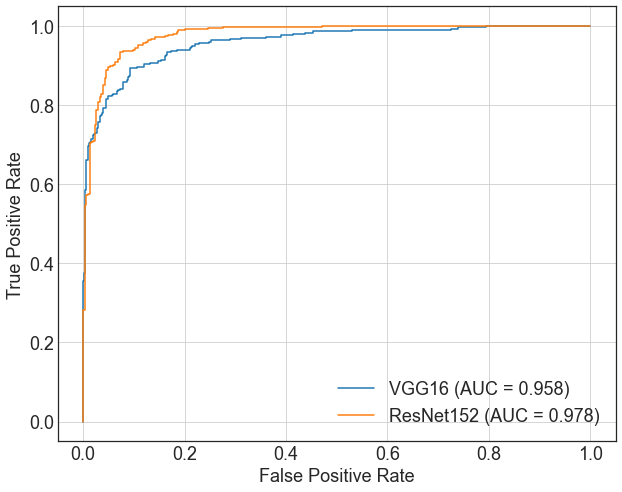

In [11]:
n1_res_auc = auc_scores['ResNet152']['n1']
n0_vgg_auc = auc_scores['VGG16']['n0']

plt.figure(figsize=(10, 8))
plt.plot(roc_values['VGG16']['n0'][0], roc_values['VGG16']['n0'][1])
plt.plot(roc_values['ResNet152']['n1'][0], roc_values['ResNet152']['n1'][1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.legend([f'VGG16 (AUC = {round(n0_vgg_auc, 3)})', f'ResNet152 (AUC = {round(n1_res_auc, 3)})'])
plt.show()

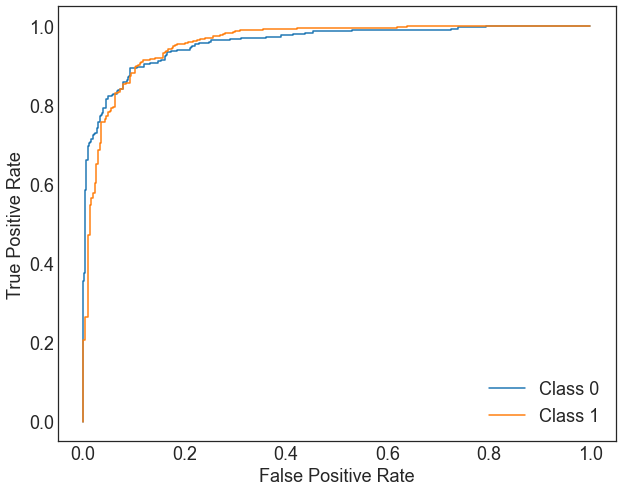

In [12]:
plt.figure(figsize=(10, 8))
plt.plot(roc_values['VGG16']['n0'][0], roc_values['VGG16']['n0'][1])
plt.plot(roc_values['VGG16']['n1'][0], roc_values['VGG16']['n1'][1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(['Class 0', 'Class 1'])

NameError: name 'fpr' is not defined

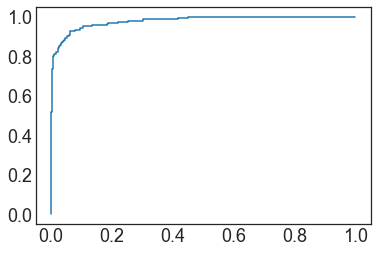

<Figure size 432x288 with 0 Axes>

In [13]:
plt.plot(roc_values['ResNet152']['n0'][0], roc_values['ResNet152']['n0'][1])
plt.figure()
plt.plot(fpr, tpr)